In [1]:
from constants import FLUXES_FOLDER, \
                      SLM_FOLDER

from data_utils import process_amp_phase_data, \
                       add_row_padding

from plot_utils import plot_map, \
                       plot_model_history, \
                       plot_autoencoder, \
                       plot_enc_conv_amp_phase_prediction


from modeling_utils import create_autoencoder_for_flux, \
                           create_convolutional_architecture_with_encoder_for_amplitude_phase_reconstruction, \
                           compile_model, \
                           train_model, \
                           store_model

from configurations import AutoEncoderConfiguration, \
                           EncoderConvolutionalConfiguration

2023-12-11 09:37:29.086906: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 09:37:29.114302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 09:37:29.114329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 09:37:29.115015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 09:37:29.119832: I tensorflow/core/platform/cpu_feature_guar

In [2]:
fluxes_filename = "all_fluxes.npy"
amplitudes_filename = "complexsine_pupamp.npy"
phases_filename = "complexsine_pupphase.npy"

fluxes_path = f"{FLUXES_FOLDER}/{fluxes_filename}"
amplitudes_path = f"{SLM_FOLDER}/{amplitudes_filename}"
phases_path = f"{SLM_FOLDER}/{phases_filename}"

In [3]:
train_fluxes_array, val_fluxes_array, train_amp_phase_array, val_amp_phase_array, scalers = \
    process_amp_phase_data(
        n_points=30000,
        trim_amplitude=False,
        trim_phase=False,
        normalize_flux=True,
        normalize_amplitude=True,
        shuffle=False,
        flatten_fluxes=False,
        split=True,
        val_ratio=0.1,
        flux_top_padding=1,
        amp_phase_top_padding=8,
        amp_phase_bottom_padding=8
    )

In [6]:
model_configuration = AutoEncoderConfiguration(train_fluxes_array)
print(model_configuration.get_description())


	=== FluxAutoencoder ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Autoencoder
		-Input shape: (56, 24)
		-Convolutional Layers: [256, 128, 16, 4] (Inverse in the decoder)
		-Convolutonal Kernels: [(3, 3), (3, 3), (3, 3), (3, 3)] (Inverse in the decoder)
		-Convolutional Activation: relu
		-Output Layer Activation: linear
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.0001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 5
		-Batch size: 32
		-Callbacks:
			-ReduceLROnPlateau: MSE 8 x0.1
			-Early Stop: MSE 15
	


2023-12-11 09:37:50.388992: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 09:37:50.470188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 09:37:50.470488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
model = create_autoencoder_for_flux(
    *model_configuration.unpack_architecture_hyperparameters()
)


Model: "FluxAutoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 24, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 24, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 12, 256)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 12, 128)       295040    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 12, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 6, 128)        0         
 g2D)                                              

In [8]:
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

In [9]:
history = train_model(
    model,
    train_fluxes_array,
    train_fluxes_array,
    val_fluxes_array,
    val_fluxes_array,
    *model_configuration.unpack_training_hyperparameters()
)

Epoch 1/5


2023-12-11 09:37:52.093273: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-11 09:37:52.222352: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 09:37:52.999028: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-11 09:37:53.603640: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff32cb7f2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-11 09:37:53.603662: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-12-11 09:37:53.612567: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702247873.696485    4429 devic

844/844 [==============================] - 42s 42ms/step - loss: 0.1824 - mean_squared_error: 0.1824 - val_loss: 0.0812 - val_mean_squared_error: 0.0812 - lr: 1.0000e-04
Epoch 2/5
844/844 [==============================] - 33s 39ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0492 - val_mean_squared_error: 0.0492 - lr: 1.0000e-04
Epoch 3/5
844/844 [==============================] - 33s 39ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - lr: 1.0000e-04
Epoch 4/5
844/844 [==============================] - 32s 38ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - lr: 1.0000e-04
Epoch 5/5
844/844 [==============================] - 32s 38ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - lr: 1.0000e-04


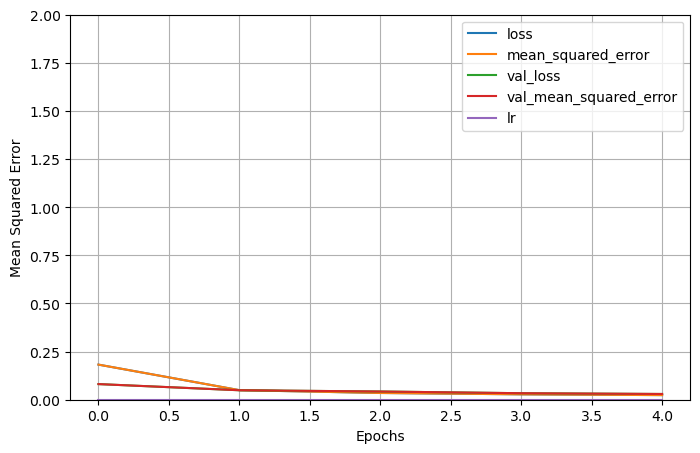

In [10]:
plot_model_history(history)

1/1 [==============================] - 0s 345ms/step


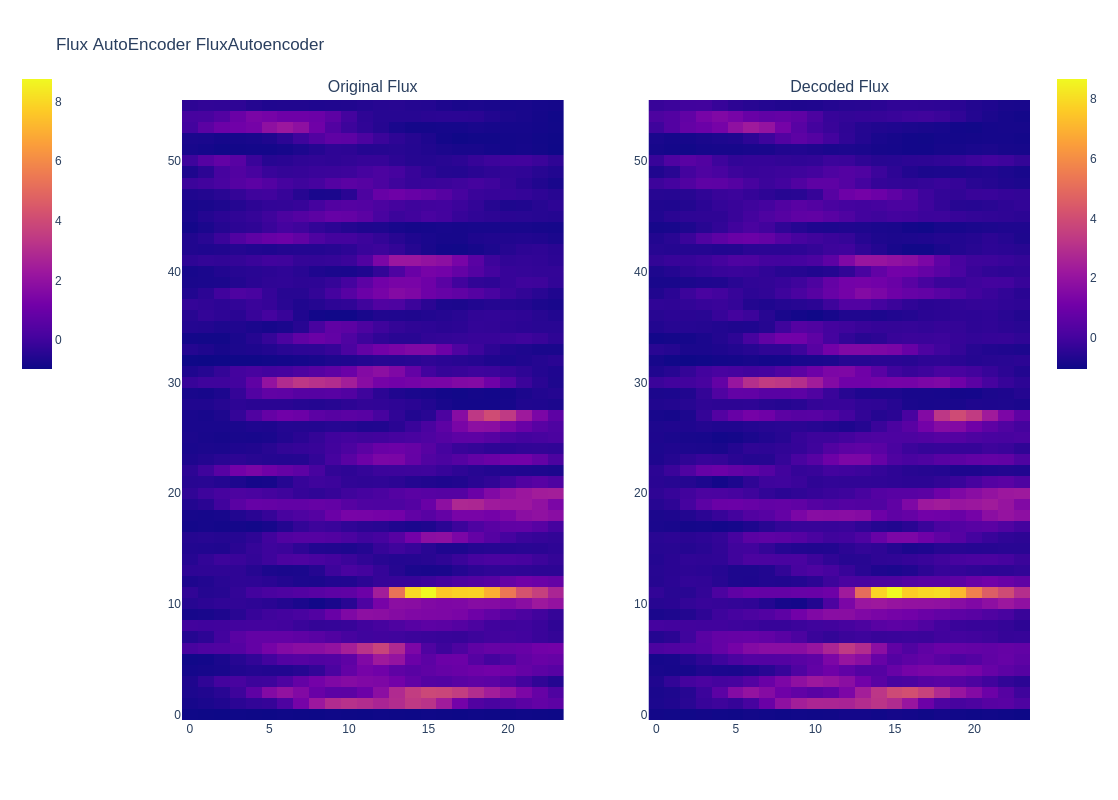

In [11]:
plot_autoencoder(model, val_fluxes_array[757])

1/1 [==============================] - 0s 13ms/step


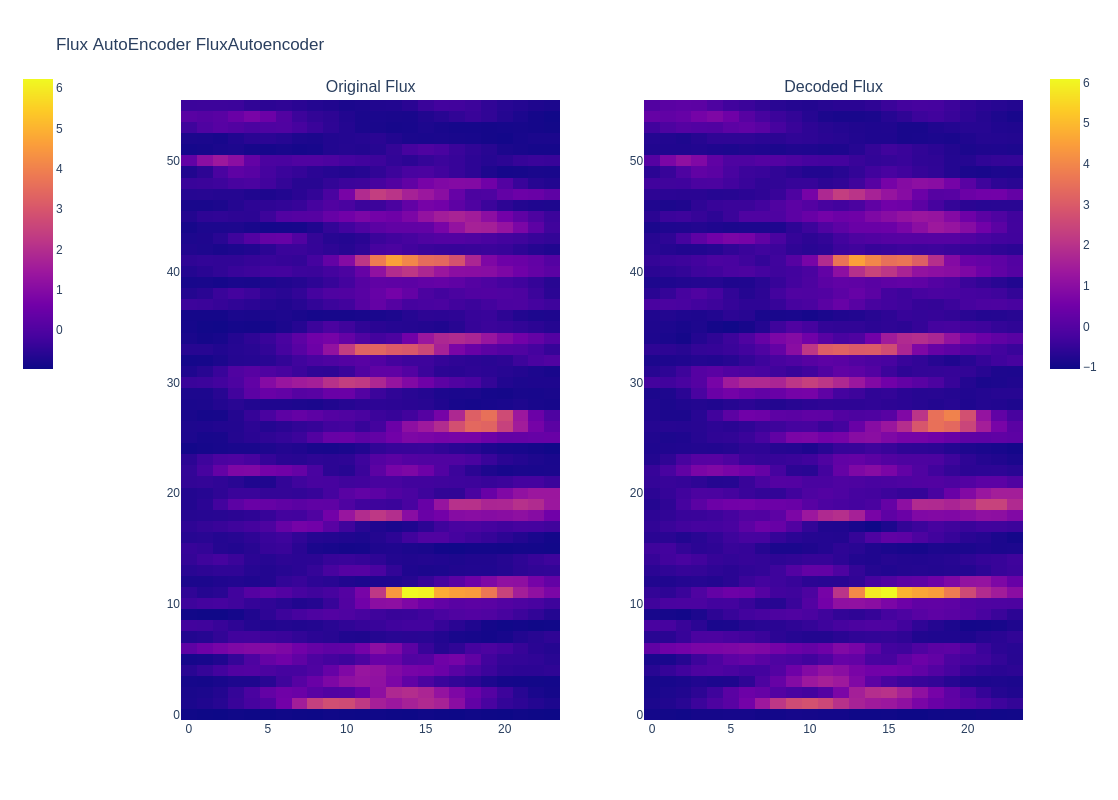

In [12]:
plot_autoencoder(model, val_fluxes_array[758])

In [13]:
store_model(model,
            model.name,
            model_configuration.get_description())

In [14]:
model_configuration = EncoderConvolutionalConfiguration()

In [15]:
enc_conv_model = create_convolutional_architecture_with_encoder_for_amplitude_phase_reconstruction(
    model,
    *model_configuration.unpack_architecture_hyperparameters())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 56, 24, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 24, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 24, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 12, 256)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 12, 128)       295040    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 12, 128)       147584    
                                                             

In [16]:
compile_model(
    enc_conv_model,
    *model_configuration.unpack_compilation_hyperparameters()
)

In [17]:
import numpy as np
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 1, 3)
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 1, 2)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 1, 3)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 1, 2)

In [ ]:

history = train_model(
    enc_conv_model,
    train_fluxes_array,
    train_amp_phase_array,
    val_fluxes_array,
    val_amp_phase_array,
    *model_configuration.unpack_training_hyperparameters()
)

Epoch 1/50


2023-12-11 09:40:50.871186: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 693.32MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-11 09:40:50.871229: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 693.32MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-11 09:40:50.871241: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 693.32MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-11 09:40:50.871252: W external/local_tsl/tsl/framewor

844/844 [==============================] - 161s 172ms/step - loss: 0.5212 - mean_squared_error: 0.5212 - val_loss: 0.4484 - val_mean_squared_error: 0.4484 - lr: 1.0000e-04
Epoch 2/50
844/844 [==============================] - 132s 156ms/step - loss: 0.4271 - mean_squared_error: 0.4271 - val_loss: 0.4196 - val_mean_squared_error: 0.4196 - lr: 1.0000e-04
Epoch 3/50
844/844 [==============================] - 132s 157ms/step - loss: 0.4104 - mean_squared_error: 0.4105 - val_loss: 0.4138 - val_mean_squared_error: 0.4138 - lr: 1.0000e-04
Epoch 4/50
844/844 [==============================] - 132s 156ms/step - loss: 0.3999 - mean_squared_error: 0.3999 - val_loss: 0.4090 - val_mean_squared_error: 0.4090 - lr: 1.0000e-04
Epoch 5/50
844/844 [==============================] - 132s 156ms/step - loss: 0.3936 - mean_squared_error: 0.3936 - val_loss: 0.3989 - val_mean_squared_error: 0.3989 - lr: 1.0000e-04
Epoch 6/50
844/844 [==============================] - 132s 156ms/step - loss: 0.3877 - mean_squa

In [ ]:
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 2, 1)
train_amp_phase_array = np.swapaxes(train_amp_phase_array, 3, 1)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 2, 1)
val_amp_phase_array = np.swapaxes(val_amp_phase_array, 3, 1)

In [ ]:
plot_enc_conv_amp_phase_prediction(enc_conv_model,
                                   train_fluxes_array[0], 
                                   train_amp_phase_array[0][0],
                                   train_amp_phase_array[0][1])

In [ ]:
plot_enc_conv_amp_phase_prediction(enc_conv_model,
                                   val_fluxes_array[0], 
                                   val_amp_phase_array[0][0],
                                   val_amp_phase_array[0][1])